In [1]:
# Import the necessary packages
import tensorflow as tf
from tensorflow import keras
from keras.initializers import glorot_uniform
from keras import backend as K
import os
import keras
from random import randint,random
import numpy as np
import matplotlib.pyplot as plt
from numpy import genfromtxt
import pandas as pd
from keras.models import Model
from keras import layers
import tensorflow as tf
from keras.applications.resnet import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.mobilenet import MobileNet
from keras.applications import inception_v3, resnet, mobilenet, vgg16, vgg19, xception
from numpy import genfromtxt
import PIL
%matplotlib inline
K.set_image_data_format('channels_last')

In [2]:
# Load the ResNet model
target_shape = (224, 224)
target_size = (224, 224)
base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=(224,224) + (3,), include_top=False
)
flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(256)(dense2)

embedding = Model(base_cnn.input, output, name="Embedding")

trainable = False
layers_ = base_cnn.layers
for layer in layers_[0:-20]:
    layer.trainable = False

In [3]:
# Define the distance layer
class DistanceLayer(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)

In [4]:
# Define the Siamese network    
anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input)),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [5]:
# Define the Siamese model class for training
class SiameseModel(Model):
    def __init__(self, siamese_network, margin=0.5):
        super().__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = keras.metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        ap_distance, an_distance = self.siamese_network(data)
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        return [self.loss_tracker]


In [6]:
# Define the floder paths
folder_path = "lfw-deepfunneled"
subfolders = [x[0] for x in os.walk(folder_path)]
subfolders = subfolders[1:]

In [7]:
# Define the image paths
people = []
for i in range(len(subfolders)):
    image_count = len([f for f in os.listdir(subfolders[i]) if os.path.isfile(os.path.join(subfolders[i], f))])
    if image_count >= 1:
        people.append([subfolders[i].split("\\")[-1], image_count])

people = sorted(people, key=lambda x: x[1], reverse=True)

In [8]:
# Check the data
print("Number of people with atleast 1 image: ", len(people))
print("Number of images: ", sum([x[1] for x in people]))
print("Number of people with atleast 2 images: ", len([x for x in people if x[1] >= 2]))


Number of people with atleast 1 image:  5749
Number of images:  13233
Number of people with atleast 2 images:  1680


In [9]:
# Select the people with atleast 5 images
selected_people = [x[0] for x in people if x[1] >= 5]
print("Number of people with atleast 5 images: ", len(selected_people))
selected_people_images = [[x,os.listdir(folder_path + "\\" + x)[0:5]] for x in selected_people]
selected_people_images[0]

Number of people with atleast 5 images:  423


['George_W_Bush',
 ['George_W_Bush_0001.jpg',
  'George_W_Bush_0002.jpg',
  'George_W_Bush_0003.jpg',
  'George_W_Bush_0004.jpg',
  'George_W_Bush_0005.jpg']]

In [10]:
# Make the triplets
triplets = []
for index,[person,images] in enumerate(selected_people_images):
    for i in range(4):
        for j in range(i+1,5):
            anchor = images[i]
            positive = images[j]
            random_class = index
            while random_class == index:
                random_class = randint(0, len(selected_people_images)-1)            
            random_image = randint(0, 4)
            negative_person = selected_people_images[random_class][0]
            negative = selected_people_images[random_class][1][random_image]
            triplets.append([folder_path+"\\"+person+"\\"+anchor, folder_path+"\\"+person+"\\"+positive, folder_path+"\\"+negative_person+"\\"+negative])

In [11]:
# Function to preprocess the image
def preprocess_image(filename):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels = 3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_size)
    return image

In [12]:
# Function to plot the images
def plot_images(triplets,index):
    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    fig = plt.figure(figsize=(7,12))
    axis = fig.subplots(10, 3)
    
    for i in range(0,index):
        anchor,positive,negative = triplets[index+i]
        show(axis[i,0], preprocess_image(anchor))
        show(axis[i,1], preprocess_image(positive))
        show(axis[i,2], preprocess_image(negative))

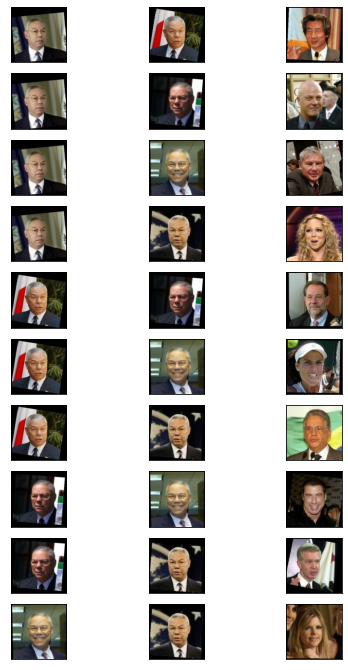

In [13]:
# Test the plot function
plot_images(triplets,10)

In [14]:
# Function to preprocess the triplets
def preprocess_triplets(anchor, positive, negative):
    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative)
    )

In [15]:
# Shuffle the triplets
np.random.shuffle(triplets)

# Load the triplets into the dataset object and preprocess them
anchor_images = [a[0] for a in triplets]
positive_images = [a[1] for a in triplets]
negative_images = [a[2] for a in triplets]

anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)
negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)

dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(preprocess_triplets)

In [16]:
# Split the dataset into training and validation
training_data = dataset.take(round(image_count * 0.8))
validation_data = dataset.skip(round(image_count * 0.8))

training_data = training_data.batch(16, drop_remainder=False)
training_data = training_data.prefetch(64)

validation_data = validation_data.batch(16, drop_remainder=False)
validation_data = validation_data.prefetch(64)

In [17]:
# Train the model
import time
start = time.time()
epochs = 10
model = SiameseModel(siamese_network)
model.compile(optimizer=keras.optimizers.Adam(0.0001),weighted_metrics=[])
model.built = True
model.load_weights('siamese_network_weights.h5')
history = model.fit(training_data, epochs=epochs, validation_data=validation_data)
stop = time.time()
print(f'Training on GPU took: {(stop-start)/60} minutes')

Epoch 1/10
1/1 [==============================] - 100s 100s/step - loss: 0.7061 - val_loss: 5.5099
Epoch 2/10
1/1 [==============================] - 81s 81s/step - loss: 6.1071 - val_loss: 5.0224
Epoch 3/10
1/1 [==============================] - 81s 81s/step - loss: 0.0000e+00 - val_loss: 4.8123
Epoch 4/10
1/1 [==============================] - 82s 82s/step - loss: 0.0000e+00 - val_loss: 4.7051
Epoch 5/10
1/1 [==============================] - 82s 82s/step - loss: 0.0000e+00 - val_loss: 4.6316
Epoch 6/10
1/1 [==============================] - 82s 82s/step - loss: 0.0000e+00 - val_loss: 4.6480
Epoch 7/10
1/1 [==============================] - 83s 83s/step - loss: 10.0050 - val_loss: 4.2978
Epoch 8/10
1/1 [==============================] - 86s 86s/step - loss: 0.0000e+00 - val_loss: 4.0978
Epoch 9/10
1/1 [==============================] - 114s 114s/step - loss: 7.8870 - val_loss: 4.0968
Epoch 10/10
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00

KeyboardInterrupt: 

In [18]:
# Save the model's weights
import json
model.save_weights("siamese_network_weights.h5")
config = model.to_json()
with open("siamese_network_config.json", "w") as json_file:
    json.dump(config, json_file)

In [19]:
# Plot the loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss during training')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

In [20]:
# Retrieve a datapoint from the dataset
sample = next(iter(training_data))
anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (embedding(inputs = resnet.preprocess_input(anchor)),
                                                            embedding(inputs = resnet.preprocess_input(positive)), 
                                                            embedding(inputs = resnet.preprocess_input(negative)))


In [21]:
# Calculate the distance between the anchor and its positive and negative images
d1 = np. sum(np. power((anchor_embedding-positive_embedding),2))
print(f'Anchor-positive difference = {d1}')

d2 = np. sum(np. power((anchor_embedding-negative_embedding),2))
print(f'Anchor-negative difference = {d2}')

Anchor-positive difference = 10.565223693847656
Anchor-negative difference = 22.11766815185547


In [22]:
# Calculate the cosine similarity between the anchor and its positive and negative images
cosine_similarity = keras.metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())

Positive similarity: 0.9999298
Negative similarity 0.99994004


In [23]:
# Function to calculate the embedding of an image
def image_to_embedding(image_path, model):
   img = preprocess_image(image_path)
   img = tf.expand_dims(img, axis=0)
   embedding_ = embedding.predict(img)
   return embedding_

In [24]:
# Store the embeddings of the images in the database
start = time.time()
database = {}
for person in os.listdir(folder_path):
    database[person] = image_to_embedding(folder_path+"\\"+person+"\\"+os.listdir(folder_path+"\\"+person)[0], embedding).tolist()
stop = time.time()
print(f'Embedding the database took: {(stop-start)/60} minutes')

1/1 [==============================] - 0s 31ms/step
Embedding the database took: 16.68038408358892 minutes


In [25]:
import json
with open("embeddings.json", "w") as outfile:
    json.dump(database, outfile)

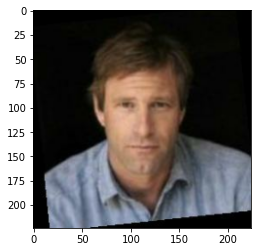

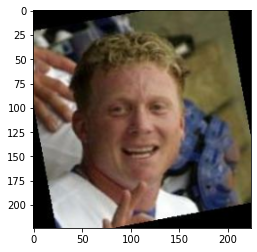

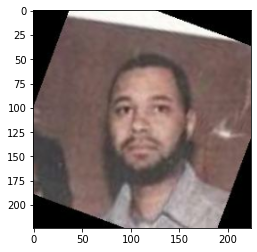

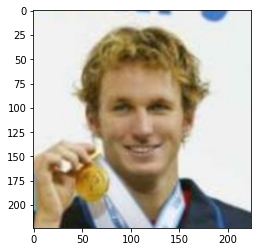

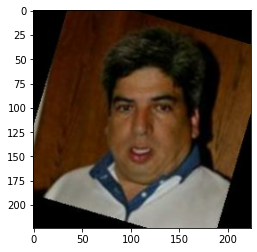

In [26]:
# Show the the first 5 images in the database
persons = list(database.keys())
for person in persons[0:5]:
    plt.imshow(preprocess_image(folder_path+"\\"+person+"\\"+os.listdir(folder_path+"\\"+person)[0]))
    plt.show()

In [27]:
# Function to verify the identity of a person
def verify(image_path,identity,database,model,thresh=1):
    encoding = image_to_embedding(image_path,model)
    dist = np.linalg.norm(encoding-np.array(database[identity]))
    if dist<thresh:
        print("Verified! It's " + str(identity))
    else:
        print("Not verified! It's not " + str(identity))
    return dist

In [28]:
def recognise(image_path,database,model,thresh=1):
    encoding = image_to_embedding(image_path,model)
    min_dist = 100
    for (name, db_enc) in database.items():
        dist = np.linalg.norm(encoding-np.array(db_enc))
        if dist<min_dist:
            min_dist = dist
            identity = name
        print("distance for "+str(name)+" is "+str(dist))
    if min_dist>thresh:
        print("Not in the database.")
    else:
        print ("it's " + str(identity) + ", the distance is " + str(min_dist))
    return min_dist, identity

In [29]:
for i in range(5):
    print(people[i][0])

George_W_Bush
Colin_Powell
Tony_Blair
Donald_Rumsfeld
Gerhard_Schroeder


1/1 [==============================] - 0s 32ms/step
Verified! It's George_W_Bush
Distance between the images: 1.81644551103076


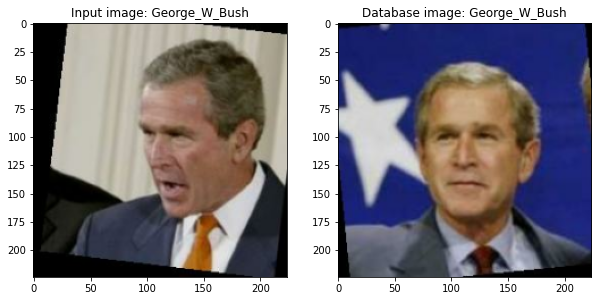

In [47]:
# Verify the identity of a person
target = "George_W_Bush"
identity = "George_W_Bush"
num = randint(1, 5)
image_path = f"{folder_path}\\{target}\\{target}_000{num}.jpg"
dist = verify(image_path,identity, database,  embedding,3)
print(f"Distance between the images: {dist}")
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(preprocess_image(image_path))
ax[0].set_title("Input image: " + target)
ax[1].imshow(preprocess_image(f"{folder_path}\\{identity}\\{identity}_0001.jpg"))
ax[1].set_title("Database image: " + identity)
plt.show()

1/1 [==============================] - 0s 27ms/step
distance for Aaron_Eckhart is 1.999500249147734
distance for Aaron_Guiel is 1.6674421769156869
distance for Aaron_Patterson is 3.2100277178132743
distance for Aaron_Peirsol is 1.410149024911502
distance for Aaron_Pena is 2.415921418034026
distance for Aaron_Sorkin is 1.4692082924251093
distance for Aaron_Tippin is 2.337821640656982
distance for Abbas_Kiarostami is 1.9368731439981586
distance for Abba_Eban is 1.7445671587471925
distance for Abdel_Aziz_Al-Hakim is 1.3523258022750984
distance for Abdel_Madi_Shabneh is 2.656225901263653
distance for Abdel_Nasser_Assidi is 2.550774595700106
distance for Abdoulaye_Wade is 1.07303034653123
distance for Abdulaziz_Kamilov is 1.3454185871932793
distance for Abdullah is 1.883295263809259
distance for Abdullah_Ahmad_Badawi is 1.9184709112401896
distance for Abdullah_al-Attiyah is 1.4598832939058324
distance for Abdullah_Gul is 2.29521192317371
distance for Abdullah_Nasseef is 1.6620602644062352
d

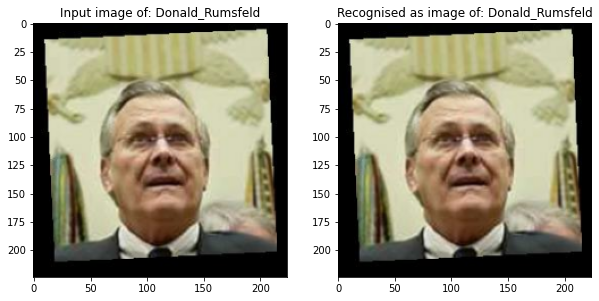

In [55]:
target = "Donald_Rumsfeld"
num = randint(1,5)
image_path = f"{folder_path}\\{target}\\{target}_000{num}.jpg"
min_dist, identity = recognise(image_path, database, embedding,1)
print(f"Minimum distance between the images: {min_dist}")
print(f"Recognised as: {identity}")
if min_dist < 0.7:
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(preprocess_image(image_path))
    ax[0].set_title("Input image of: " + target)
    ax[1].imshow(preprocess_image(f"{folder_path}\\{identity}\\{identity}_0001.jpg"))
    ax[1].set_title("Recognised as image of: " + identity)
    plt.show()